# Levelset figures

Code for creating 2D/3D levelset figures

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
np.set_printoptions(linewidth=1000)
np.set_printoptions(threshold=5000)

from tqdm.notebook import tqdm
import os
from functools import partial
from pathlib import Path
import pandas as pd
from datetime import datetime
from PIL import Image
pd.set_option('display.max_rows', 500)

from matplotlib import pyplot as plt
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib widget

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import jax
jax.config.update("jax_enable_x64", False)
import jax.numpy as jnp
import jax.random as jrnd
import orbax
import optax

import trimesh
from notebook_utils import *

import diffcd
import evaluation

from fit_implicit import load_config

import matplotlib

def load_checkpoint(experiment_dir: Path, step: int = None):
    checkpoint_manager = orbax.checkpoint.CheckpointManager(
        directory=experiment_dir / 'checkpoints',
        checkpointers=orbax.checkpoint.PyTreeCheckpointer(),
    )
    checkpoint = checkpoint_manager.restore(
        checkpoint_manager.latest_step() if step is None else step,
    )
    return checkpoint

def load_model(output_dir, checkpoint_index, final=False, with_mesh=True, normalize_mesh=False):
    if final:
        mesh_path = output_dir / f'mesh_final_{checkpoint_index}.ply'
    else:
        mesh_path = output_dir / f'meshes/mesh_{checkpoint_index}.ply'
    mesh = trimesh.load(mesh_path) if with_mesh else None
    checkpoint = load_checkpoint(output_dir, checkpoint_index)
    if normalize_mesh:
        # scale mesh to network coordinate system
        mesh.vertices = (mesh.vertices - checkpoint['center_point']) / checkpoint['scale_factor']

    config = load_config(output_dir)
    model = config.model
    params = checkpoint['model']['params']
    return model, params, config, mesh

In [3]:
# set this to the directory where outputs from fit_implicit.py are stored
base_dir = Path('/home/linus/workspace/outputs/diffcd')

## Shape info

requires blender kernel

In [4]:
import bpy
import blender_plots as bplt
from blender_plots import blender_utils as bu
import math
from notebook_utils_blender import *
import mathutils

mesh_color = np.array([0.4, 0.4, 0.4, 1])
rots = {
    'anchor': [0, 0, -np.pi / 4],
    'dc': [np.pi / 2, 0, 0],
    'gargoyle': [-np.pi / 2, 0, 0],
    'lord_quas': [np.pi / 2, 0, 0],
    'daratech': [np.pi / 2, 0, 0],
}
famous_shapes = [
    "3DBenchy",
    "Armadillo",
    "Cup34",
    "Liberty",
    "LibertyBase",
    "Utah_teapot_(solid)",
    "angel",
    "bunny",
    "column",
    "dragon",
    "eg07_dragon_original",
    "flower",
    "galera",
    "hand",
    "happy",
    "horse",
    "netsuke",
    "serapis",
    "tortuga",
    "xyzrgb_statuette",
    "yoda",
    "xyzrgb_dragon_clean",
]
shape_rots = {
    "3DBenchy": [1.973491, 0.565872, 0.397071],
    "Armadillo": [1.279329, -0.523505, -1.873030],
    "Cup34": [1.549294, -0.002934, -8.273785],
    "Liberty": [1.549294, -0.002934, -8.273785],
    "LibertyBase": [1.570796, -0.000000, -1.570796],
    "Utah_teapot_(solid)": [0.208537, 1.226459, -4.230667],
    "angel": [1.697227, -2.569600, 1.993524],
    "bunny": [1.570796, 2.560063, 1.436140],
    "column": [1.570796, -0.000000, -0.856408],
    "dragon": [3.614511, 1.313700, -2.598450],
    "eg07_dragon_original": [-0.039995, 2.332894, -1.740092],
    "flower": [1.570796, -0.000000, -1.570796],
    "galera": [1.586949, 3.807761, -2.121951],
    "hand": [-1.222986, 0.369399, -1.209566],
    "happy": [1.374851, -1.043912, -1.312685],
    "horse": [0.800892, -0.648794, -4.601765],
    "netsuke": [2.704684, -2.292917, -3.792721],
    "serapis": [2.679568, 3.240767, -1.841576],
    "tortuga": [1.994344, -0.779336, -1.327590],
    "xyzrgb_statuette": [1.884367, 2.601276, -0.911202],
    "yoda": [1.290503, -8.341380, -1.758422],
    "xyzrgb_dragon_clean": [-6.417248, 0.761268, -1.406844],
}
shape_scales = {
    "3DBenchy": 1.62193,
    "Armadillo": 1.406,
    "Cup34": 1.35815,
    "Liberty": 1.76884,
    "LibertyBase": 1.,
    "Utah_teapot_(solid)": 1.69715,
    "angel": 1.57988,
    "bunny": 1.33726,
    "column": 1.60766,
    "dragon": 1.504,
    "eg07_dragon_original": 1.40351,
    "flower": 1.51258,
    "galera": 1.44836,
    "hand": 1.5374,
    "happy": 1.49781,
    "horse": 1.45101,
    "netsuke": 1.35697,
    "serapis": 1.35714,
    "tortuga": 1.78173,
    "xyzrgb_statuette": 1.470132,
    "yoda": 1.79178,
    "xyzrgb_dragon_clean": 1.64108,
}
shape_offsets = {
    "3DBenchy": [0.079599, 0.000000, 0.208712],
    "Armadillo": [0.016001, 0.000000, 0.065363],
    "Cup34": [0, 0, 0],
    "Liberty": [0.000000, 0.000000, 0.245872],
    "LibertyBase": [0, 0, 0],
    "Utah_teapot_(solid)": [0.116799, 0.000000, 0.114277],
    "angel": [0.000000, 0.000000, 0.125678],
    "bunny": [0.061397, 0.000000, 0.154598],
    "column": [0, 0, 0],
    "dragon": [0.109435, -0.109496, 0.171271],
    "eg07_dragon_original": [-0.012576, 0.000000, -0.019602],
    "flower": [0, 0, 0],
    "galera": [0.000000, 0.000000, 0.101243],
    "hand": [0.000000, 0.000000, 0.032701],
    "happy": [0.000000, 0.000000, 0.078420],
    "horse": [0.000000, 0.000000, 0.062099],
    "netsuke": [0.000000, 0.000000, 0.040873],
    "serapis": [0.000000, 0.000000, 0.109389],
    "tortuga": [-0.094460, 0.000000, 0.046627],
    "xyzrgb_statuette": [-0.043312, 0.000000, 0.078419],
    "yoda": [0.144047, 0.000000, 0.068654],
    "xyzrgb_dragon_clean": [0.091593, 0.000000, 0.178902],
}

shape_R = {shape_name: euler_to_R(rot) for shape_name, rot in shape_rots.items()}


abc_shapes = [
    '00010218_4769314c71814669ba5d3512_trimesh_013',
    '00010429_fc56088abf10474bba06f659_trimesh_004',
    '00011000_8a21002f126e4425a811e70a_trimesh_004',
    '00011171_db6e2de6f4ae4ec493ebe2aa_trimesh_047',
    '00011563_26a622427a024bf3af381ee6_trimesh_014',
    '00011602_c087f04c99464bf7ab2380c4_trimesh_000',
    '00011696_1ca1ad2a09504ff1bf83cf74_trimesh_029',
    '00011827_73c6505f827541168d5410e4_trimesh_096',
    '00012076_bd0ba1071db44a4cb05e612c_trimesh_011',
    '00012275_eb932687cefd46ec9539dff8_trimesh_012',
    '00012324_4abcf5e80b7e46eeae89a8d1_trimesh_011',
    '00012451_f54bcfcb352445bf90726b58_trimesh_001',
    '00012754_b17656deace54b61b3130c7e_trimesh_019',
    '00012756_b17656deace54b61b3130c7e_trimesh_021',
    '00012809_c478c020bc394c7a9ee59016_trimesh_000',
    '00012830_9302b464ff7a454a9404b130_trimesh_001',
    '00013052_9084b77631834dd584b2ac93_trimesh_033',
    '00013453_056d6da46d5d4183875e63e0_trimesh_000',
    '00013698_4e525fcfdb0b458fbe78eff7_trimesh_007',
    '00013858_5f60dba564944f9fbb15dc2c_trimesh_001',
    '00014101_7b2cf2f0fd464e80a5062901_trimesh_000',
    '00014155_a04f003ab9b74295bbed8248_trimesh_000',
    '00014221_57e4213b31844b5b95cc62cd_trimesh_000',
    '00014228_fb174aafb16d47abab609285_trimesh_002',
    '00014393_4898b9df95db421ca3eeae4d_trimesh_022',
    '00014405_4898b9df95db421ca3eeae4d_trimesh_034',
    '00014452_55263057b8f440a0bb50b260_trimesh_017',
    '00014489_f4297f01e3434034b7051ebb_trimesh_004',
    '00014859_1d8dd0a5ddec465fad59927b_trimesh_009',
    '00014952_e862f9e2bc81472a91a31206_trimesh_001',
    '00015156_57353d3381fb481182d9bdc6_trimesh_010',
    '00015159_57353d3381fb481182d9bdc6_trimesh_013',
]

thing_shapes = [
    '103354',
    '120477',
    '199664',
    '236159',
    '252119',
    '274379',
    '313444',
    '316358',
    '331105',
    '353684',
    '353686',
    '354371',
    '398259',
    '42468',
    '44234',
    '46459',
    '46460',
    '46461',
    '46462',
    '46463',
    '47984',
    '527631',
    '53159',
    '53920',
    '54725',
    '58982',
    '59941',
    '64194',
    '64444',
    '64764',
    '68380',
    '68381',
    '70558',
    '70559',
    '72870',
    '72879',
    '72881',
    '72896',
    '72947',
    '72948',
    '72960',
    '73075',
    '73101',
    '73133',
    '73998',
    '75147',
    '75275',
    '75496',
    '75650',
    '75651',
    '75652',
    '75653',
    '75654',
    '75655',
    '75656',
    '75657',
    '75658',
    '75659',
    '75660',
    '75661',
    '75662',
    '75663',
    '75665',
    '75667',
    '75810',
    '76277',
    '76391',
    '76947',
    '76948',
    '77245',
    '77319',
    '77513',
    '78671',
    '79241',
    '80650',
    '81368',
    '81369',
    '81528',
    '81762',
    '82536',
    '83022',
    '83229',
    '84986',
    '85540',
    '85546',
    '85699',
    '86848',
    '88053',
    '90889',
    '91347',
    '92763',
    '92880',
    '93101',
    '93497',
    '93989',
    '95187',
    '95444',
    '96483',
    '96637',
    '98480',
]

camera_location = [-0.991957, -2.175998, 0.181080]
camera_rotation = [1.523696, 0.000002, -0.431984]

# Teaser figure (3D shape + 2D levelset slice)

In [5]:
setup_scene(
	clear=True,
	camera_location=[-1.944018, -1.888456, 0.085236],
	camera_rotation=[1.649391, 0.000009, -0.730459],
	resolution=(512*2, 512*2)
)

In [12]:
import mathutils
from fit_implicit import TrainingConfig

shape_name = 'bunny'
rot_shape = shape_rots[shape_name]
scale_shape = shape_scales[shape_name]
offset_shape = shape_offsets[shape_name]


# output_dir = base_dir / f'run-famous_noisefree-diffcd-implicit-256-l2-lr0.001-2024-02-12_12:23:27/bunny' # DiffCD
output_dir = base_dir / f'run-famous_noisefree-igr-l2-2024-02-10_15:41:30/bunny' # IGR
idx = 40000

checkpoint = load_checkpoint(output_dir, idx)
config = load_config(output_dir)
# mesh = trimesh.load(output_dir / 'mesh_final_40000.ply')
mesh = trimesh.load(output_dir / f'meshes/mesh_{idx}.ply')
mesh_object, scatter = plot_mesh(
    mesh,
    color=mesh_color,
    scale=scale_shape,
    center=False,
    name=f"np-ours",
    rotation=rot_shape,
    offset=offset_shape,
    text_color=(1, 0, 0, 1),
)
params = checkpoint['model']['params']

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) / 255 for i in range(0, lv, lv // 3))


train_points = np.load(output_dir / 'train_points.npy')
train_points_denormalized = checkpoint['scale_factor'] * train_points + checkpoint['center_point']
point_color = hex_to_rgb('071863')
scatter = bplt.Scatter(
    train_points_denormalized * scale_shape,
    marker_type='spheres', radius=0.007,
    color=point_color,
)
scatter.base_object.rotation_euler = rot_shape
scatter.base_object.location = offset_shape

/home/linus/workspace/diffcd/notebook_utils.py:151: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(np.hstack([u1[:, None], u2[:, None]]), np.hstack([(mu1 - mu0)[:, None], (mu2 - mu0)[:, None]]))[0]


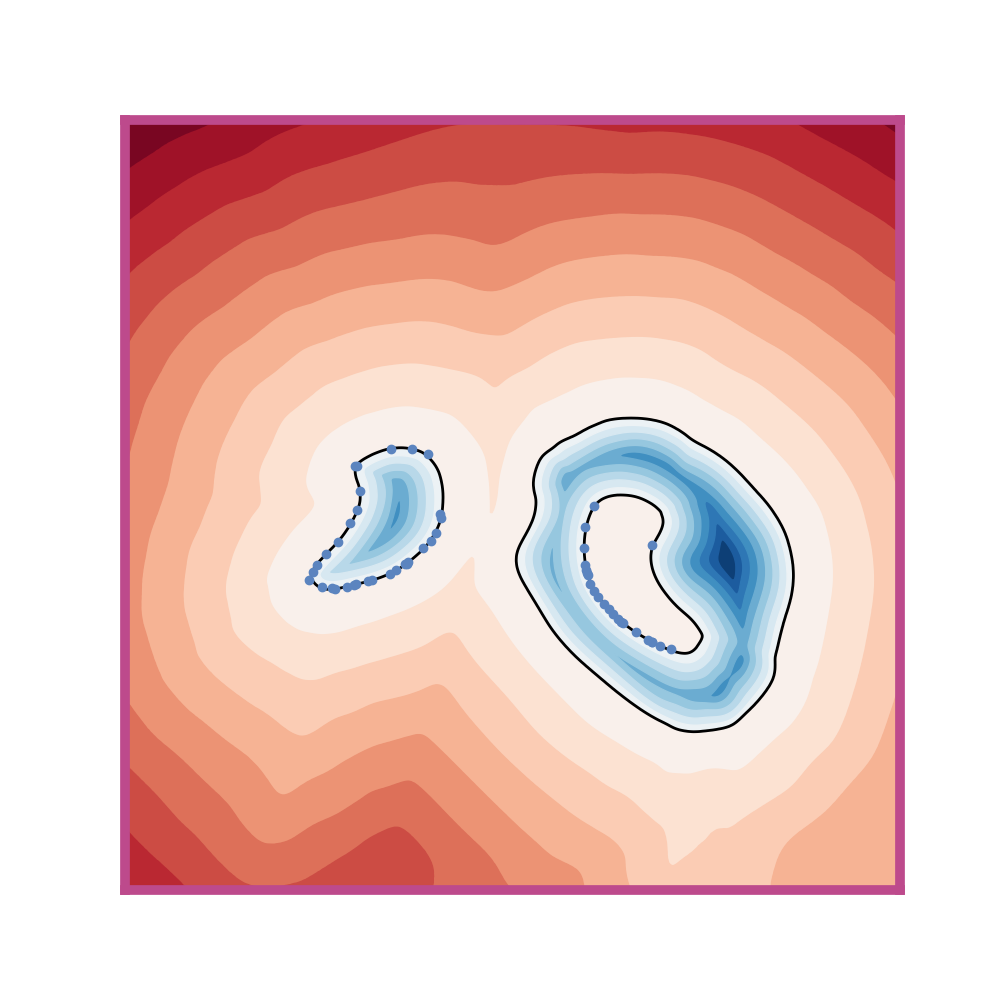

In [13]:
def transform(R, t, p):
    return np.einsum('ij, ...j->...i', R, p) + t
R_shape = np.array(mathutils.Euler(rot_shape).to_matrix())


## To move the plane: apply a transform in the blender viewer and copy the transform values (Location and Rotation) to here using ctrl+shift+c
offset_plane = [-0.209343, 0.213689, 0.633870]
rot_plane = [-0.485054, 3.307150, 1.853334]

offset_plane = np.array(offset_plane)
R_plane = np.array(mathutils.Euler(rot_plane).to_matrix())
v0, v1, v2 = (
    jnp.array([0., 0., -0.]),
    jnp.array([0.55, 0., -0.]),
    jnp.array([0., 0.55, -0.]),
)

u1, u2, x1, x2 = get_basis(v0, v1, v2, preserve_norm=True, preserve_angle=True)
taus = get_range(0, 500, symmetric=True, )
taus1, taus2 = jnp.meshgrid(taus, taus)
inputs_basis = v0 + taus1[..., None] * u1 + taus2[..., None] * u2

inputs_blender_coords = transform(R_plane, offset_plane, inputs_basis)
inputs = transform(R_shape.T, -R_shape.T @ np.array(offset_shape), inputs_blender_coords) / scale_shape
inputs = (inputs - checkpoint['center_point']) / checkpoint['scale_factor']

outputs = config.model.apply(params, inputs)

outputs_normalized = NonSymmetricNormalize()(outputs)
bins = np.linspace(0, 1, 20)
outputs_normalized = bins[np.digitize(NonSymmetricNormalize()(outputs).data, bins=bins) - 1]

level_cmap = plt.get_cmap('RdBu_r')
levelset_colors = level_cmap(outputs_normalized)
levelset_colors[..., 3] = 0.95
plane_slice = bplt.Surface(
    inputs_basis,
    color=levelset_colors,
    name='plane slice',
)
plane_slice.base_object.rotation_euler = rot_plane
plane_slice.base_object.location = offset_plane

border = bplt.Surface(
    inputs_basis[::len(inputs_basis)-1, ::len(inputs_basis)-1],
    color=level_cmap(bins[-1]),
    name='border',
)
border.base_object.rotation_euler = rot_plane
border.base_object.location = offset_plane

modifier = bu.add_modifier(
    border.base_object,
    "WIREFRAME",
    use_crease=False,
    crease_weight=10,
    thickness=0.02,
    use_boundary=True,
)
modifier = bu.add_modifier(border.base_object, "BEVEL", segments=5,)


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_sdf_surface(ax, jnp.stack([taus1, taus2], axis=-1), outputs, hide_ticks=True)

n = np.cross(u1 - v0, u2 - v0)
n /= np.linalg.norm(n)

train_points_blender_coords = transform(R_shape, np.array(offset_shape), train_points_denormalized * scale_shape)
train_points_basis = transform(R_plane.T, -R_plane.T @ offset_plane, train_points_blender_coords)
ax.plot(
    (train_points_basis[np.abs((train_points_basis - v0) @ n) < .5e-2] - v0) @ u1 / np.linalg.norm(u1) ** 2,
    (train_points_basis[np.abs((train_points_basis - v0) @ n) < .5e-2] - v0) @ u2 / np.linalg.norm(u2) ** 2,
    'o',
    # color=point_color,
    color='#5b84bf',
    label='point cloud',
)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(7)
    spine.set_edgecolor('#bd4a8c')

if False:
    bplt.Arrows(
        transform(R_plane, offset_plane, v0),
        end=transform(R_plane, offset_plane, u1),
        radius=0.01,
        head_length=0.03,
        name='arrow x',
        color=(1, 0, 0),
    )
    bplt.Arrows(
        transform(R_plane, offset_plane, v0),
        end=transform(R_plane, offset_plane, u2),
        radius=0.01,
        head_length=0.03,
        name='arrow y',
        color=(0, 1, 0),
    )

# Surface point sampling comparison

In [6]:
setup_scene(clear=True, camera_location=[-0.158831, 0.018522, 0.696356], camera_rotation=[0.128313, 0.000002, 5.924651])
color = [0.3, 0.3, 0.3, 1]

shape_name = 'bunny'
rot = shape_rots[shape_name]
R = np.array(mathutils.Euler(rot).to_matrix())

output_dir = base_dir / f'run-famous_noisefree-diffcd-implicit-256-l2-lr0.001-2024-02-12_12:23:27/{shape_name}'
model, params, config, mesh = load_model(output_dir, 20000, final=False, with_mesh=True, normalize_mesh=True)
mesh = evaluation.meshing.extract_mesh(
    evaluation.meshing.Meshing(points_per_axis=128), # set to 512 to match paper
    partial(model.apply, params),
)

mesh_object, scatter = plot_mesh(
    mesh,
    color=color,
    scale=1,
    center=False,
    name=f"np-ours",
    rotation=rot,
    text_color=(1, 0, 0, 1),
)

2024-07-26 17:16:04.164615: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [7]:
query_point = R.T @ np.array([-.1, .1, .3]) # for bunny on hear # camera: [-0.117041, -0.197596, 1.151987], [0.303711, 0.000002, 6.351327]
closest_color = lighten_color(mpl_colors[4], 2.1)
pull_color = lighten_color(mpl_colors[3], 1.7)

radius = 0.004
scatter = bplt.Scatter(
    query_point,
    marker_type='ico_spheres',
    # marker_type='spheres',
    radius=radius,
    # subdivisions=3,
    color=[0, 0, 0],
    name='query_point'
)
scatter.base_object.rotation_euler = rot

f, g = jax.value_and_grad(partial(model.apply, params))(query_point)
pulled_point = query_point - f * g
scatter = bplt.Scatter(
    pulled_point,
    marker_type='ico_spheres',
    # marker_type='spheres',
    radius=radius,
    subdivisions=3,
    color=pull_color,
    name='pulled_point'
)
scatter.base_object.rotation_euler = rot

newton_config = diffcd.newton.NewtonConfig(max_iters=1000, stop_when_converged=True, grad_norm_eps=1e-6)
closest, state, valid = diffcd.closest_point.closest_point_newton(model.apply, params, query_point, pulled_point, newton_config)
scatter = bplt.Scatter(
    closest,
    marker_type='ico_spheres',
    # marker_type='spheres',
    radius=radius,
    subdivisions=3,
    color=closest_color,
    name='closest_point'
)
scatter.base_object.rotation_euler = rot

quiver = bplt.Arrows(
    query_point,
    end=closest,
    head_length=0.008,
    radius=0.002,
    radius_ratio=2.3,
    end_trim_length=radius * 1.3,
    name='closest point',
    color=closest_color,
)
quiver.base_object.rotation_euler = rot

quiver = bplt.Arrows(
    query_point,
    end=pulled_point,
    head_length=0.008,
    radius=0.002,
    radius_ratio=2.3,
    end_trim_length=radius * 1.3,
    name='pulled point',
    color=pull_color,
)
quiver.base_object.rotation_euler = rot

/home/linus/workspace/diffcd/notebook_utils.py:151: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(np.hstack([u1[:, None], u2[:, None]]), np.hstack([(mu1 - mu0)[:, None], (mu2 - mu0)[:, None]]))[0]


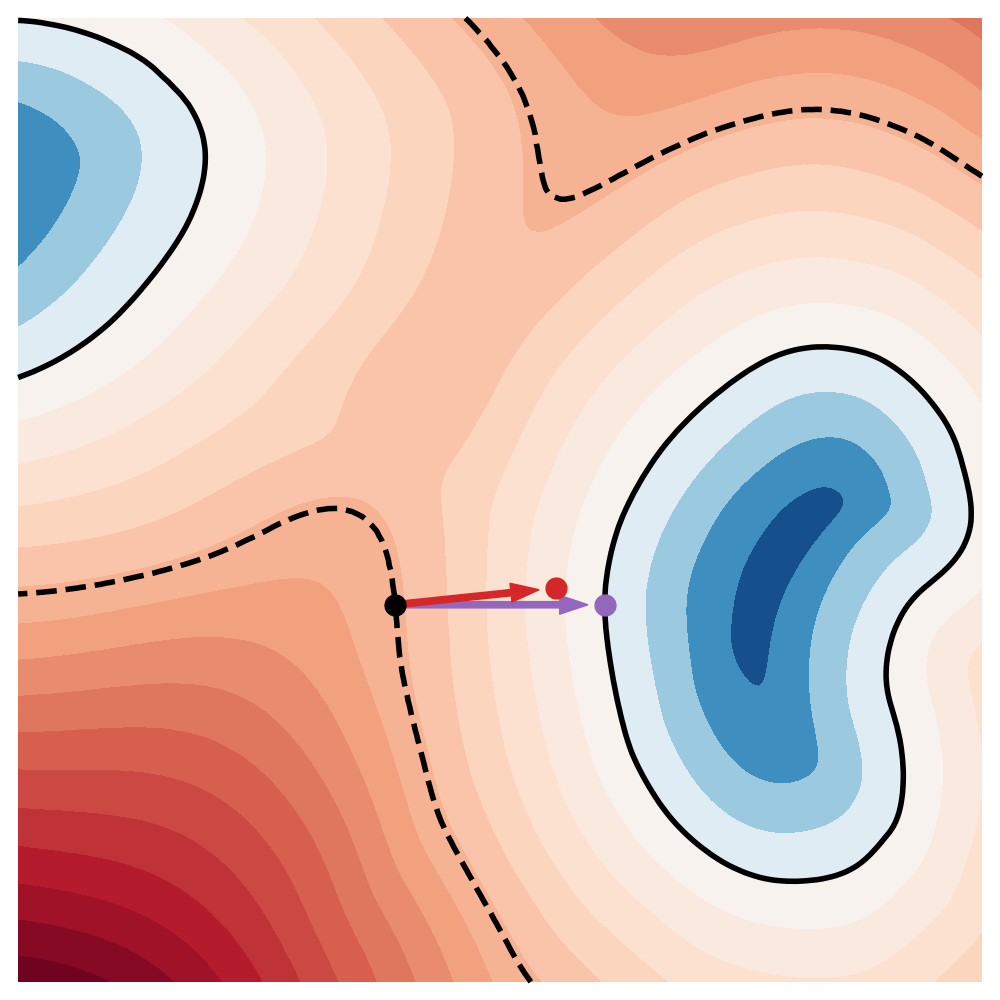

In [8]:
closest_color = mpl_colors[4]
pull_color = mpl_colors[3]

u1, u2, x1, x2 = get_basis(query_point, closest, pulled_point)
taus = get_range(
    1.8,
    200,
)
taus1, taus2 = jnp.meshgrid(taus, taus)
inputs = query_point + taus1[..., None] * u1 + taus2[..., None] * u2
outputs = model.apply(params, inputs)

box = bplt.Surface(
    inputs[::len(inputs)-1, ::len(inputs)-1],
    color=(1, 0, 0,),
    name='bbox'
)
box.base_object.rotation_euler = rot

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

v, n, lw, ms = 10, 20, 4, 15
img = ax.contourf(taus1, taus2, outputs, cmap='RdBu_r', levels=n, norm=NonSymmetricNormalize())
ax.contour(taus1, taus2, outputs, colors='k', vmin=-v, vmax=v, levels=[0], linewidths=lw)
ax.contour(taus1, taus2, outputs, colors='k', vmin=-v, vmax=v, levels=[model.apply(params, query_point)], linewidths=lw, linestyles='--')
ax.plot([], [], 'k-', linewidth=lw, label=r'$f(x) = 0$')
ax.plot([], [], 'k--', linewidth=lw, label=r'$f(x) = f(\tilde x)$')

ax.plot(0, 0, 'ok', label=r'query point $\tilde x$', markersize=ms)
ax.plot(*x1, 'o', color=closest_color, label=r'closest point', markersize=ms, zorder=5)
ax.plot(*x2, 'o', color=pull_color, label=r'pulled point $\tilde x - fg$', markersize=ms, zorder=5)

def trim(v, d):
    v_norm = np.linalg.norm(v)
    return v / v_norm * (v_norm - d)
ax.arrow(0, 0, *trim(x1, 0.08), color=closest_color, length_includes_head=True, width=0.03)
ax.arrow(0, 0, *trim(x2, 0.08), color=pull_color, length_includes_head=True, width=0.03)

ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axis('equal')
fig.tight_layout()

# 2D surface fitting

## spurious surface

2D block with two vertical details attached. Leaves behind a spurious surface for IGR, similar to the bunny ears in Fig. 1. 

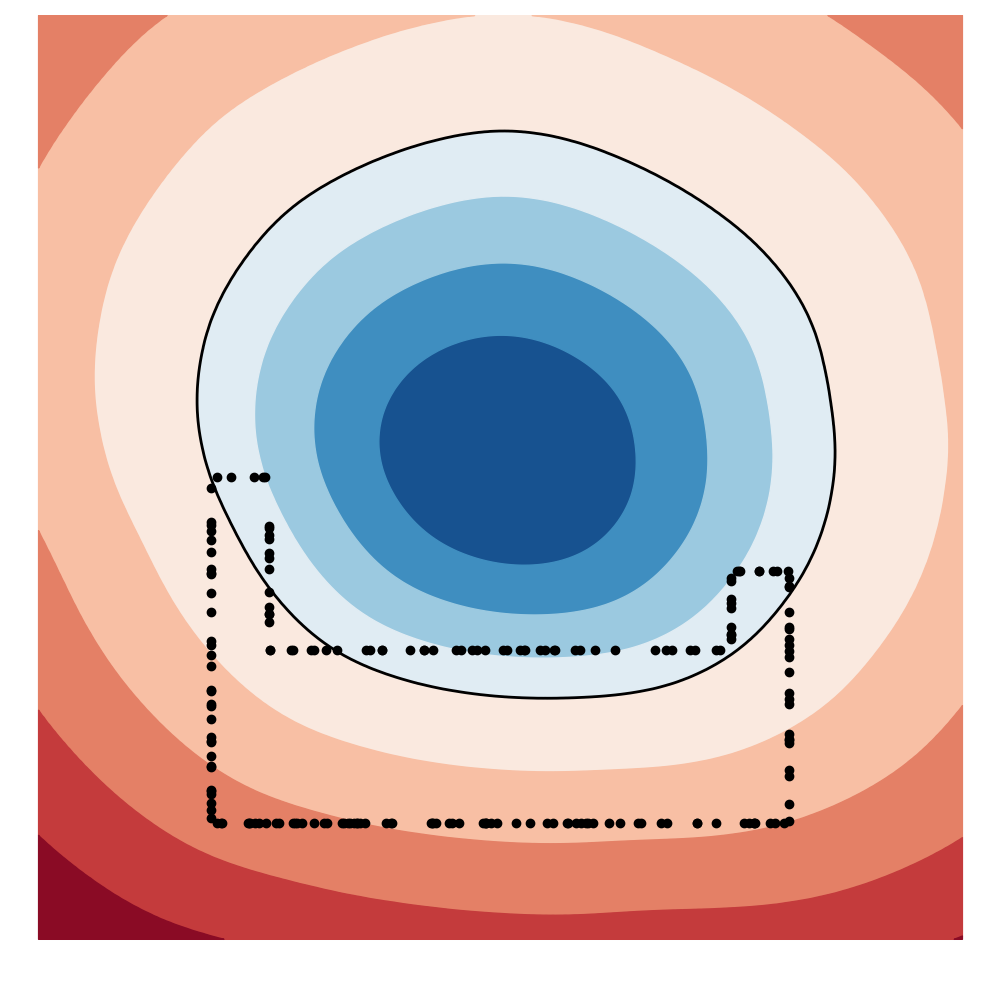

In [80]:
model = diffcd.networks.MLP(128, 5, activation_function=diffcd.networks.ActivationFunction.SOFTPLUS, geometry_init=True)

init_params = model.init(jrnd.PRNGKey(20), jnp.array([1, -1]))
r = .8
lower_bound, upper_bound = (-r, -r), (r, r)

inputs = get_grid(lower_bound, upper_bound, n=500)
sdf_values = model.apply(init_params, inputs)

width = 2
base_height = .6
height = 1.2
n_teeth = 4
tooth_width = .2
vertices = [[0, 0]]
for i, start in enumerate(np.linspace(0, width - tooth_width, n_teeth)):
    vertices += [
        [start, base_height],
    ]
    if i in [0, n_teeth - 1]:
        vertices += [
            [start, height * (0.9) ** i],
            [start + tooth_width, height * (0.9) ** i],
        ]
    vertices += [
        [start+tooth_width, base_height],
    ]
vertices += [[width, 0]]
vertices = .5*np.array(vertices) - np.array([0.5, .6])

edges = np.array([
        list(range(0, len(vertices))),
        list(range(1, len(vertices))) + [0],
    ]
).T

contour = evaluation.contours.Contour(
    vertices, edges,
)
train_points, normals = evaluation.contours.get_sample_points(contour, 200)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_sdf_surface(ax, inputs, sdf_values, n_positive_levels=5, n_negative_levels=5)
ax.plot(*train_points.T, 'ok', label='train points')
ax.axis('equal')
fig.tight_layout()

In [21]:
from datetime import datetime
timestamp_str = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
fig.savefig(f'images/box-init{timestamp_str}.png', bbox_inches='tight', pad_inches=0.)
fig.savefig(f'images/box-init{timestamp_str}.pdf', bbox_inches='tight', pad_inches=0.)

In [75]:
from diffcd.methods import DiffCDState, SurfaceSamples
from diffcd.training import ShapeTrainState

# since surface sampling in DiffCD is based on trimesh we need to overwrite get_batch to work with 2D surfaces
class DiffCD2D(diffcd.methods.DiffCD):
    def get_batch(self, train_state: ShapeTrainState, state: DiffCDState, key, batch_size):
        _, *batch = diffcd.methods.IGR.get_batch(self, train_state, state, key, batch_size)
        if self.s2p_weight != 0:
            if (train_state.step % self.surface_sampling.mesh_interval == 0):
                # update surface sampling mesh
                inputs = get_grid(
                    min=self.surface_sampling.surface_meshing.lower_bound,
                    max=self.surface_sampling.surface_meshing.upper_bound,
                    n=self.surface_sampling.num_samples,
                )
                sdf_values = train_state.apply_fn(train_state.params, inputs)
                sampling_contour = evaluation.contours.get_contour(inputs, sdf_values)
                mesh_samples, _ = evaluation.contours.get_sample_points(sampling_contour, self.surface_sampling.num_samples)
                state = DiffCDState(state.point_cloud, state.local_sigma, state.point_cloud_kd_tree, mesh_samples)

            surface_samples = self.get_surface_samples(
                key, train_state.apply_fn, train_state.params, state.mesh_samples, state.point_cloud, batch_size
            )
        else:
            surface_samples = SurfaceSamples(jnp.array([]), jnp.array([]), jnp.array([]))
        return state, *batch, surface_samples


In [94]:
batch_size = 5000
train_state = diffcd.training.ShapeTrainState.create(
    apply_fn=model.apply,
    tx=optax.adam(1e-3),
    params=init_params,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
)
key = jrnd.PRNGKey(0)

## IGR
method = diffcd.methods.IGR(
    eikonal_weight=.1, distance_metric='l2',
    sampling=diffcd.samplers.SamplingConfig(samples_per_point=1, global_samples=1000, k=5),
)

## SIREN
# method = diffcd.methods.IGR(
#     eikonal_weight=.1, distance_metric='l2',
#     sampling=diffcd.samplers.SamplingConfig(samples_per_point=1, global_samples=1000, k=5),
#     surface_area_weight=0.33 * (r ** 2 / r ** 3), # compensate for |\Omega| in scale factor (see paragraph after eq. 17)
#     surface_area_samples=5000,
# )

## DiffCD
# method = DiffCD2D(
#     eikonal_weight=.1, distance_metric='l2', p2s_loss='implicit',
#     sampling=diffcd.samplers.SamplingConfig(samples_per_point=1, global_samples=1000, k=5),
#     surface_sampling=diffcd.samplers.SurfaceSamplingConfig(
#         num_samples=batch_size,
#         mesh_interval=500,
#         newton=diffcd.newton.NewtonConfig(max_iters=4),
#         surface_meshing=evaluation.meshing.Meshing(lower_bound=lower_bound, upper_bound=upper_bound)
#     )
# )

method_state = method.init_state(key, train_points, None)
step_params = [init_params]
for i in tqdm(range(10000), leave=False):
    key, = jrnd.split(key, 1)
    method_state, *batch = method.get_batch(train_state, method_state, key, batch_size)
    metrics, train_state, nan_grads = method.step(train_state, *batch)
    if i % 100 == 0:
        step_params.append(train_state.params)
params = train_state.params

  0%|          | 0/10000 [00:00<?, ?it/s]

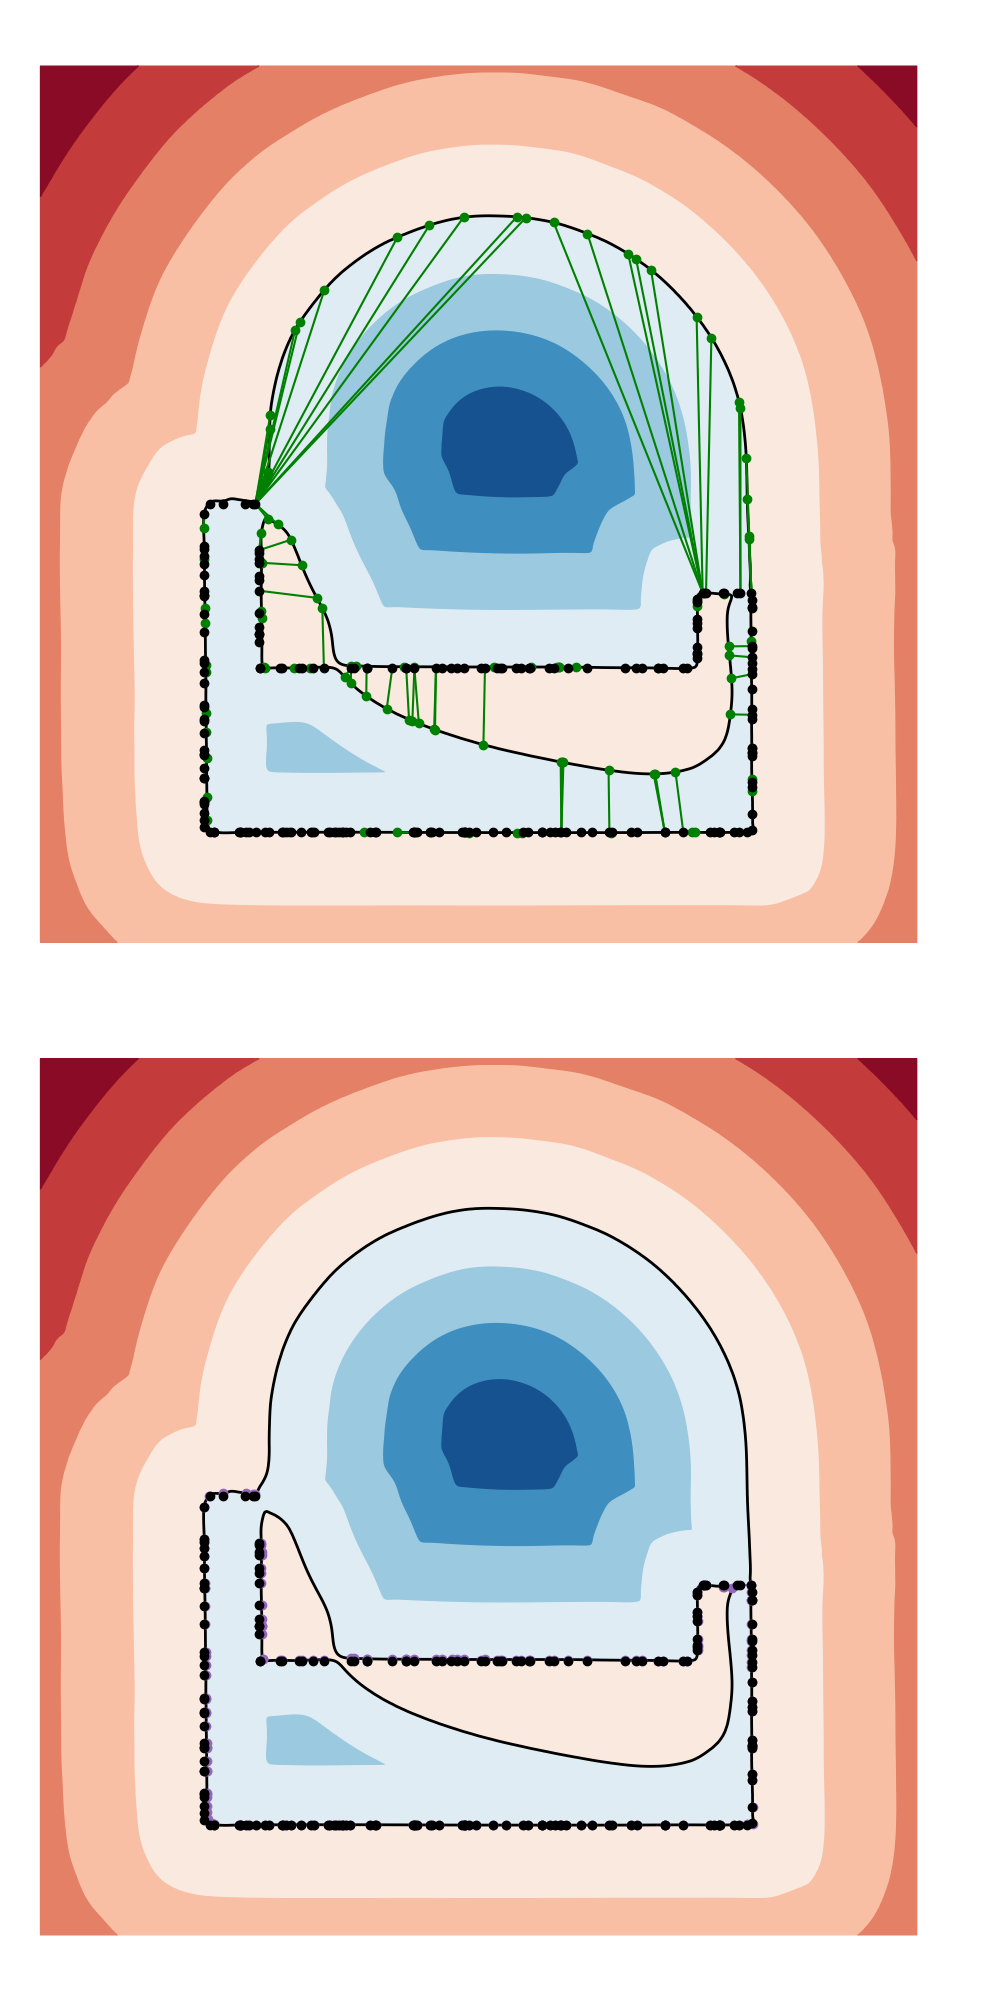

In [95]:
params = step_params[-1]
inputs = get_grid(lower_bound, upper_bound, n=500)

sdf_values = model.apply(params, inputs)
fig, ax = plt.subplots(2, 1, figsize=(10, 20))

for a in ax:
    plot_sdf_surface(a, inputs, sdf_values, n_positive_levels=5, n_negative_levels=5)
    a.plot(*train_points.T, 'ok', label='train points', zorder=5)

sdf_values = train_state.apply_fn(params, inputs)
sampling_contour = evaluation.contours.get_contour(inputs, sdf_values)
mesh_samples, _ = evaluation.contours.get_sample_points(sampling_contour, 100)

closest_points = jax.vmap(diffcd.methods.point_cloud_closest_point, in_axes=(0, None))(jnp.array(mesh_samples), jnp.array(train_points))

ax[0].plot(*mesh_samples.T, 'og')
for start, end in zip(mesh_samples, closest_points):
    ax[0].plot(*np.vstack([start, end]).T, '-g')

closest_points_surface, newton_state, valid = diffcd.closest_point.closest_point_newton_batch(
    train_state.apply_fn, params, train_points, diffcd.newton.NewtonConfig()
)
ax[1].plot(*closest_points_surface.T, 'o', color=mpl_colors[4])
for start, end in zip(train_points[valid], closest_points_surface[valid]):
    ax[1].plot(*np.vstack([start, end]).T, '-', color=mpl_colors[4])


for a in ax:
    a.axis('equal')
fig.tight_layout()

In [96]:
from datetime import datetime
timestamp_str = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
fig.savefig(f'images/shape_2d{timestamp_str}.png', bbox_inches='tight', pad_inches=0.)
fig.savefig(f'images/shape_2d{timestamp_str}.pdf', bbox_inches='tight', pad_inches=0.)

## Sparse box

2D box with sparsely sampled points. Illustrates how Neural-Pull struggles with sparse point clouds.

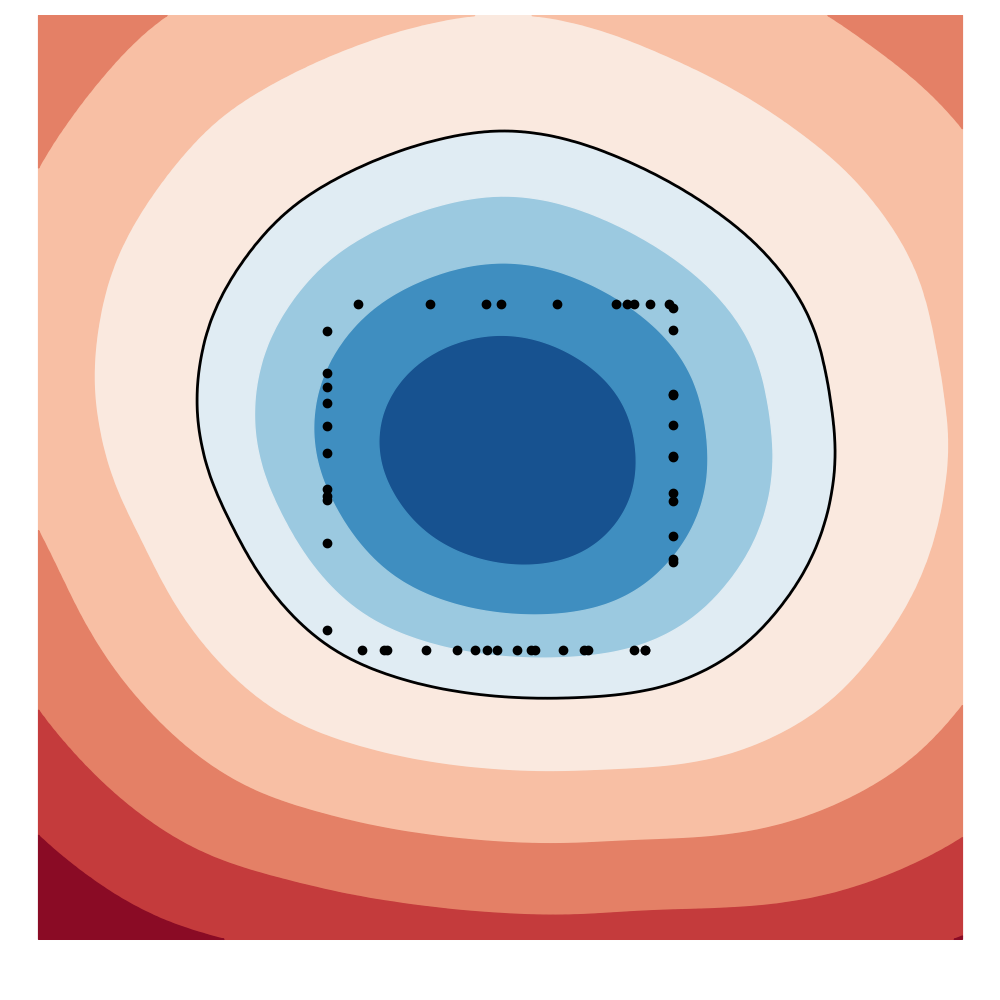

In [109]:
model = diffcd.networks.MLP(128, 5, activation_function=diffcd.networks.ActivationFunction.SOFTPLUS, geometry_init=True)

init_params = model.init(jrnd.PRNGKey(20), jnp.array([1, -1]))
r = .8
lower_bound, upper_bound = (-r, -r), (r, r)

inputs = get_grid(lower_bound, upper_bound, n=500)
sdf_values = model.apply(init_params, inputs)

width, height = 1.2, 1.2
vertices = np.array([
    [-width/2, height/2],
    [width/2, height/2],
    [width/2, -height/2],
    [-width/2, -height/2],
])

vertices = np.array([
    [height / 2, height / 2],
    [-height / 2, height / 2],
    [-height / 2, -height / 2],
    [height / 2, -height / 2],
]) * .5

edges = np.array([
        list(range(0, len(vertices))),
        list(range(1, len(vertices))) + [0],
    ]
).T

contour = evaluation.contours.Contour(
    vertices, edges,
)
train_points, normals = evaluation.contours.get_sample_points(contour, 50)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_sdf_surface(ax, inputs, sdf_values, n_positive_levels=5, n_negative_levels=5)
ax.plot(*train_points.T, 'ok', label='train points')
ax.axis('equal')
fig.tight_layout()

In [130]:
batch_size = 1000
train_state = diffcd.training.ShapeTrainState.create(
    apply_fn=model.apply,
    tx=optax.adam(1e-3),
    params=init_params,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
)
key = jrnd.PRNGKey(0)

## IGR
# method = diffcd.methods.IGR(
#     eikonal_weight=.1, distance_metric='l2',
#     sampling=diffcd.samplers.SamplingConfig(samples_per_point=1, global_samples=1000, k=5),
# )

## Neural-Pull
method = diffcd.methods.NeuralPull(
    distance_metric='l2',
    sampling=diffcd.samplers.SamplingConfig(samples_per_point=10,k=10)
)

## DiffCD
# method = DiffCD2D(
#     eikonal_weight=.1, distance_metric='l2', p2s_loss='implicit',
#     sampling=diffcd.samplers.SamplingConfig(samples_per_point=1, global_samples=1000, k=5),
#     surface_sampling=diffcd.samplers.SurfaceSamplingConfig(
#         num_samples=batch_size,
#         mesh_interval=500,
#         newton=diffcd.newton.NewtonConfig(max_iters=4),
#         surface_meshing=evaluation.meshing.Meshing(lower_bound=lower_bound, upper_bound=upper_bound)
#     )
# )

method_state = method.init_state(key, train_points, None)
step_params = [init_params]
for i in tqdm(range(10000), leave=False):
    key, = jrnd.split(key, 1)
    method_state, *batch = method.get_batch(train_state, method_state, key, batch_size)
    metrics, train_state, nan_grads = method.step(train_state, *batch)
    if i % 100 == 0:
        step_params.append(train_state.params)
params = train_state.params

  0%|          | 0/10000 [00:00<?, ?it/s]

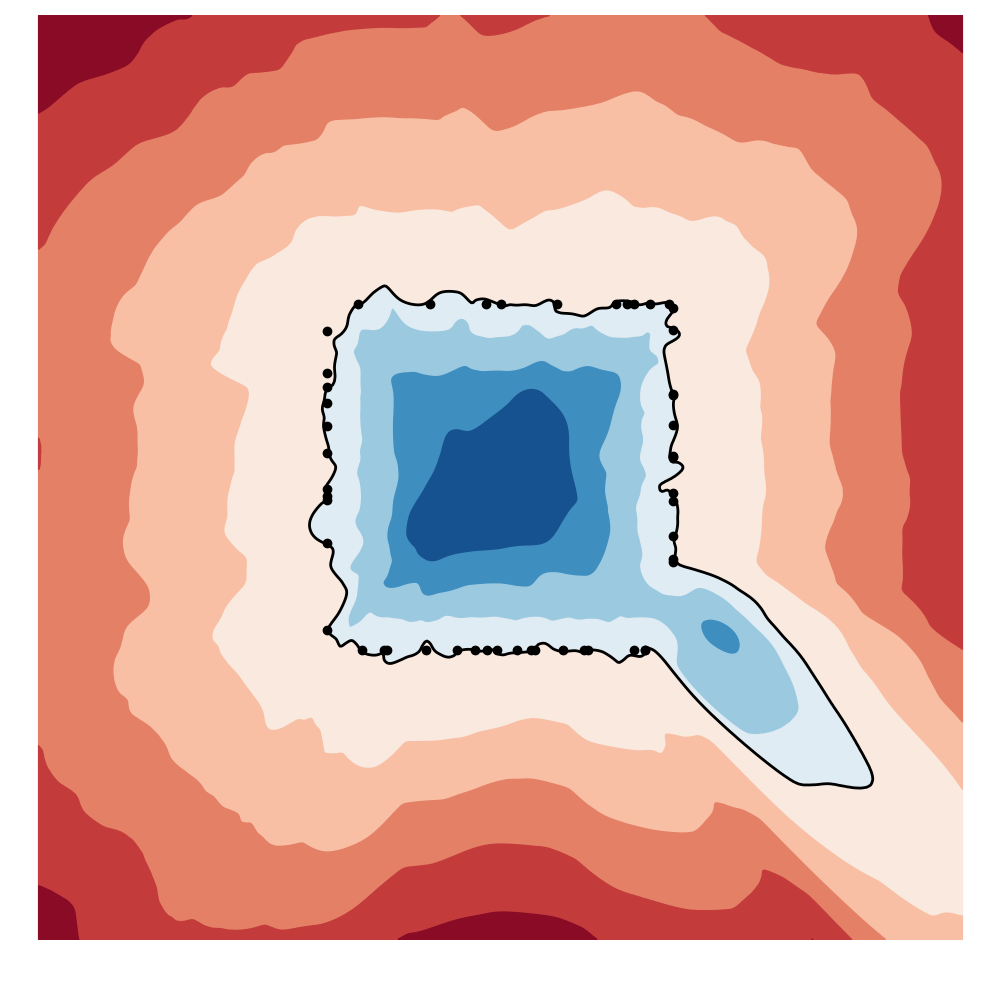

In [131]:
params = step_params[-1]
inputs = get_grid(lower_bound, upper_bound, n=500)

sdf_values = model.apply(params, inputs)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plot_sdf_surface(ax, inputs, sdf_values, n_positive_levels=5, n_negative_levels=5)
ax.plot(*train_points.T, 'ok', label='train points', zorder=5)

sdf_values = train_state.apply_fn(params, inputs)
sampling_contour = evaluation.contours.get_contour(inputs, sdf_values)
mesh_samples, _ = evaluation.contours.get_sample_points(sampling_contour, 100)

ax.axis('equal')
fig.tight_layout()